## Modèles à moyenne mobile - MA(q)

Les modèles MA(q) sont très similaires aux modèles AR(p). Le modèle MA(q) est une combinaison linéaire de termes d'erreur passés par opposition à une combinaison linéaire d'observations passées comme le modèle AR(p). La motivation du modèle MA est que nous pouvons expliquer les "chocs" dans le processus d'erreur directement en ajustant un modèle aux termes d'erreur. (Dans un modèle AR(p), ces chocs sont observés indirectement en utilisant les observations passées)

$$x_t=w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$
Où $w_t$ est un bruit blanc avec $E(w_t)=0$ et variance $\sigma^2$.

Par définition, ACF $ρ_k$ devrait être égal à zéro pour k>q.

Simulons ce processus en utilisant $\beta$=0,6 et en spécifiant le AR(p) $\alpha$ égal à 0.

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2014/12/31'
endDateStr = '2017/12/31'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC','DOW','AAPL','MSFT', 'SPX']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1)).fillna(0)

Processing data for stock: ^GSPC
Processing data for stock: DOW
Processing data for stock: AAPL
Processing data for stock: MSFT
Processing data for stock: SPX
20% done...
40% done...
60% done...
80% done...


In [5]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

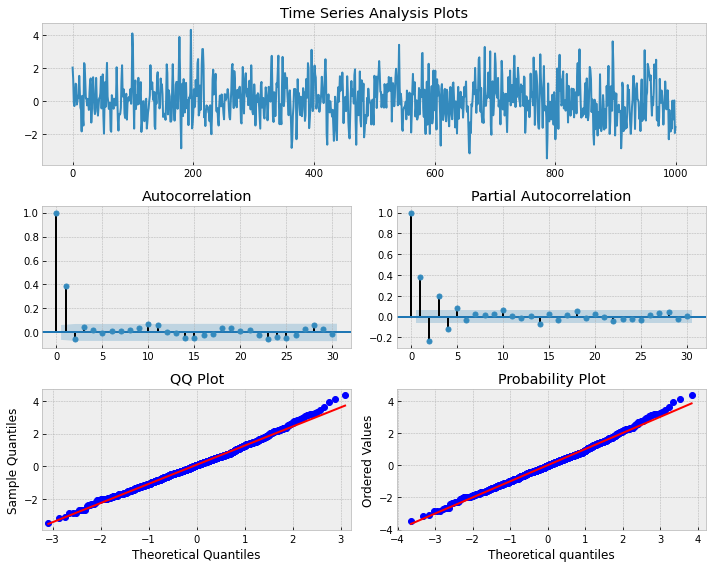

In [6]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)


Puisque q=1, nous prévoyons un pic significatif à k=1 à l'ACF et ensuite des pics non significatifs par la suite.

Tout comme nous utilisons l'ACF pour les modèles AR(p), c'est un moyen utile de voir si un modèle MA(q) est approprié. En examinant l'ACF d'une série particulière, nous pouvons voir combien de décalages séquentiels non nuls existent. Si q de tels décalages existent, nous pouvons alors légitimement tenter d'adapter un modèle MA(q) à une série particulière.

La fonction ACF montre que le décalage 1 est significatif, ce qui indique qu'un modèle MA(1) peut être approprié pour notre série simulée. Nous pouvons maintenant essayer d'ajuster un modèle MA(1) à nos données simulées.

In [7]:
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1441.653
Method:                           mle   S.D. of innovations              1.023
Date:                Tue, 29 Sep 2020   AIC                           2887.307
Time:                        19:46:39   BIC                           2897.122
Sample:                             0   HQIC                          2891.037
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6156      0.027     23.162      0.000       0.563       0.668
                                    Roots                                    
                  Real          Imaginary           M

Le modèle a pu estimer correctement le coefficient de décalage puisque 0,58 est proche de notre valeur réelle de 0,6. Notez également que notre intervalle de confiance à 95 % contient la valeur réelle.

In [9]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

The residuals seem normally distributed.


Essayons de simuler un processus MA(3), puis essayons d'ajuster un modèle MA d'ordre 3 à la série et voyons si nous pouvons récupérer les bons coefficients de décalage ($\beta s$). Les bêtas 1-3 sont respectivement égaux à 0,3, 0,2 et 0,1. Cette fois, nous devons nous attendre à des pics significatifs à k = {1,2,3}, et à des pics non significatifs pour k>3 dans les parcelles ACF.

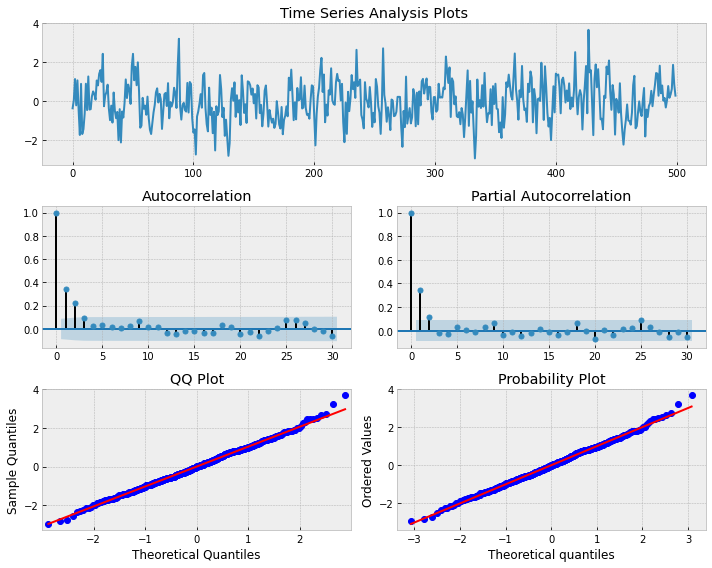

In [10]:
# Simulate MA(3) process with betas 0.3, 0.2, 0.1

n = int(500)
alphas = np.array([0.])
betas = np.array([0.3, 0.2, 0.1])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [11]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  500
Model:                     ARMA(0, 3)   Log Likelihood                -686.943
Method:                           mle   S.D. of innovations              0.956
Date:                Tue, 29 Sep 2020   AIC                           1381.887
Time:                        19:49:32   BIC                           1398.745
Sample:                             0   HQIC                          1388.502
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.3065      0.045      6.859      0.000       0.219       0.394
ma.L2.y        0.2211      0.046      4.847      0.000       0.132       0.311
ma.L3.y        0.0795      0.043      1.849      0.0

In [13]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

The residuals seem normally distributed.


Le modèle a permis d'estimer efficacement les coefficients réels. Nos intervalles de confiance à 95 % contiennent également les valeurs réelles des paramètres 0,3, 0,2 et 0,1.

Suivons maintenant l'exercice précédent et ajustons un modèle MA(1) aux rendements logarithmiques de l'AAPL et traçons à nouveau les résidus. 

C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:                   AAPL   No. Observations:                  757
Model:                     ARMA(0, 1)   Log Likelihood                2135.691
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 29 Sep 2020   AIC                          -4267.382
Time:                        19:50:30   BIC                          -4258.123
Sample:                             0   HQIC                         -4263.816
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.AAPL     0.0301      0.038      0.798      0.425      -0.044       0.104
                                    Roots                                    
                  Real          Imaginary           M

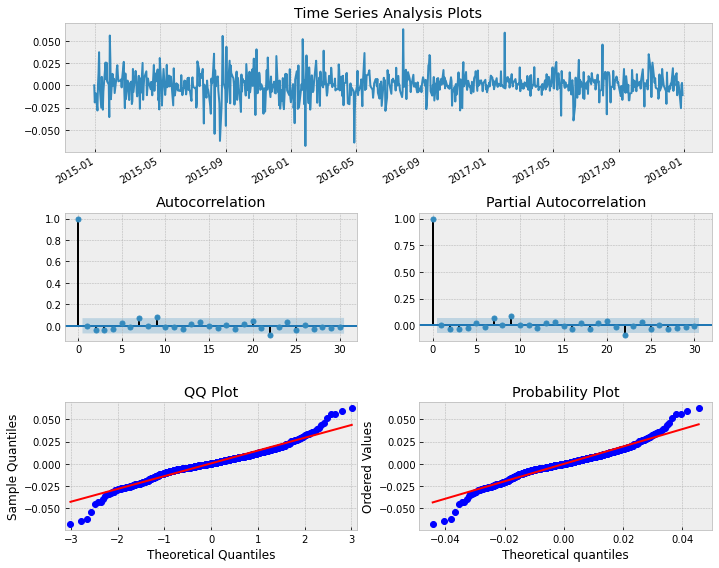

In [14]:
# Fit MA(1) to AAPL log returns

max_lag = 30
Y = lrets.AAPL
mdl = smt.ARMA(Y, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:                   AAPL   No. Observations:                  757
Model:                     ARMA(0, 2)   Log Likelihood                2136.251
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 29 Sep 2020   AIC                          -4266.501
Time:                        19:51:22   BIC                          -4252.613
Sample:                             0   HQIC                         -4261.152
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.AAPL     0.0260      0.036      0.714      0.476      -0.045       0.098
ma.L2.AAPL    -0.0398      0.038     -1.059      0.290      -0.114       0.034
                                    Roots           

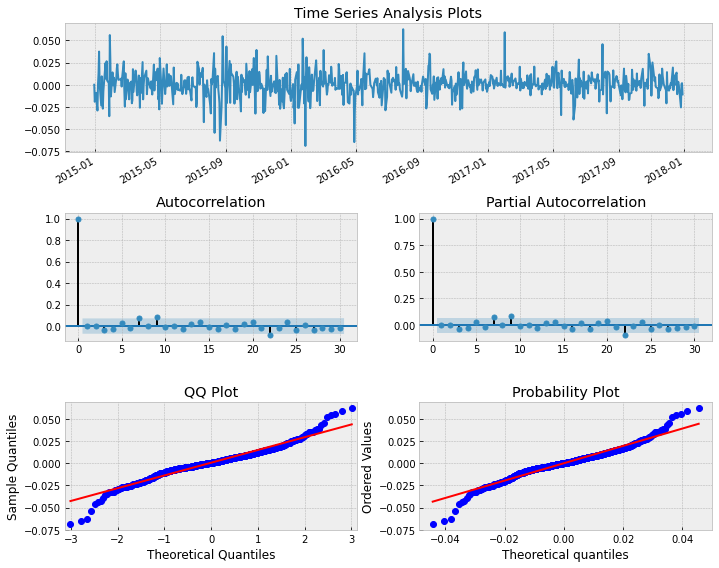

In [15]:
# Fit MA(2) to AAPL log returns

max_lag = 30
Y = lrets.AAPL
mdl = smt.ARMA(Y, order=(0, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

Nous voyons des pics marginalement significatifs à k=4, k=16. Cela suggère que le modèle MA(2) saisit une grande partie de l'autocorrélation, mais pas tous les effets à mémoire longue. Nous pourrions continuer à augmenter l'ordre, mais nous continuerions à remarquer ces pics parce que nous ajouterons un nouveau paramètre à un modèle qui semble avoir expliqué une grande partie des corrélations à plus court terme, mais qui n'aura pas beaucoup d'effet sur les décalages à long terme.

Tous ces éléments suggèrent qu'un modèle MA(q) n'est probablement pas utile pour expliquer toute la corrélation en série de manière isolée, au moins pour l'AAPL.

In [17]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:                    SPX   No. Observations:                  757
Model:                     ARMA(0, 3)   Log Likelihood                -737.505
Method:                           mle   S.D. of innovations              0.640
Date:                Tue, 29 Sep 2020   AIC                           1483.010
Time:                        19:53:16   BIC                           1501.527
Sample:                             0   HQIC                          1490.142
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPX     -0.8391      0.036    -23.096      0.000      -0.910      -0.768
ma.L2.SPX     -0.0382      0.048     -0.795      0.426      -0.132       0.056
ma.L3.SPX     -0.0341      0.036     -0.940      0.3

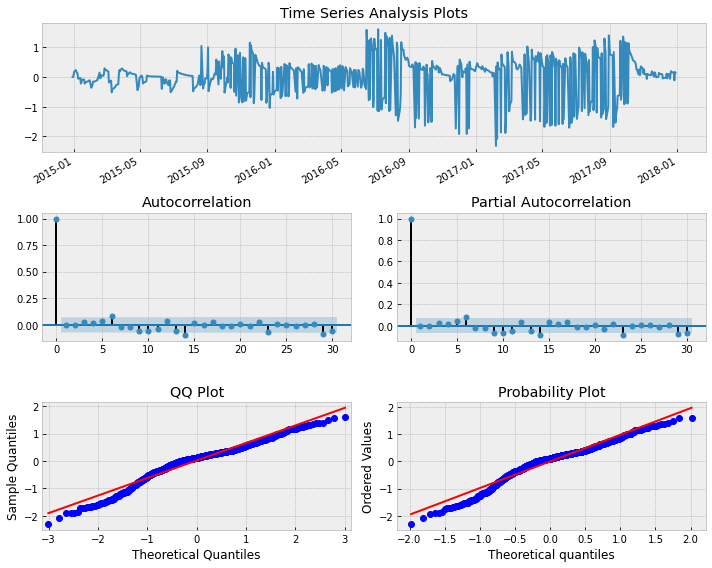

In [20]:
# Fit MA(3) to SPX log returns

max_lag = 30
Y = lrets.SPX
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

In [21]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


Nous avons maintenant examiné en détail deux grands modèles de séries chronologiques, à savoir le modèle autogressif d'ordre p, AR(p) et ensuite la moyenne mobile d'ordre q, MA(q). Nous avons vu qu'ils sont tous deux capables d'expliquer une partie de l'autocorrélation des résidus des prix journaliers différés de premier ordre des actions et des indices, mais le regroupement de la volatilité et les effets de mémoire longue persistent.

Il est enfin temps de se pencher sur la combinaison de ces deux modèles, à savoir la moyenne mobile autorégressive d'ordre p,q, ARMA(p,q) pour voir si elle permet d'améliorer encore la situation.